# DEEPFAKE DETECTION MODEL

### Install Required Packages

In [ ]:
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install facenet-pytorch
!pip install albumentations
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install tqdm
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import All Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import timm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import json
import random
from tqdm import tqdm
import pickle
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import kagglehub

### Set Random Seeds and Device Configuration

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
CUDA available: True
GPU: Tesla T4
GPU Memory: 14.7 GB


### Setup Project Directories

In [ ]:
base_dir = '/content/drive/MyDrive/deepfake_detection'
os.makedirs(base_dir, exist_ok=True)
os.makedirs(f'{base_dir}/data', exist_ok=True)
os.makedirs(f'{base_dir}/models', exist_ok=True)
os.makedirs(f'{base_dir}/results', exist_ok=True)

print("Project directories created successfully!")
print(f"Base directory: {base_dir}")
print(f"Data directory: {base_dir}/data")
print(f"Models directory: {base_dir}/models")
print(f"Results directory: {base_dir}/results")

Project directories created successfully!
Base directory: /content/drive/MyDrive/deepfake_detection
Data directory: /content/drive/MyDrive/deepfake_detection/data
Models directory: /content/drive/MyDrive/deepfake_detection/models
Results directory: /content/drive/MyDrive/deepfake_detection/results


### Load Kaggle Dataset

Dataset Link: https://www.kaggle.com/datasets/xdxd003/ff-c23

In [ ]:
def load_kaggle_ff_dataset():
    try:
        path = kagglehub.dataset_download("xdxd003/ff-c23")
        dataset_path = os.path.join(path, "FaceForensics++_C23")

        if os.path.exists(dataset_path):
            return dataset_path
        else:
            if os.path.exists(path):
                print(f"Using path: {path}")
                return path
            else:
                print("Dataset not found!")
                return None
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Load the dataset
dataset_path = load_kaggle_ff_dataset()
print(f"Dataset path: {dataset_path}")

100%|██████████| 16.7G/16.7G [04:39<00:00, 64.0MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/xdxd003/ff-c23/versions/1/FaceForensics++_C23


### Explore the dataset structure

In [ ]:
def print_dataset_structure(root_dir, indent=0):
    if not os.path.exists(root_dir):
        print("Dataset path does not exist!")
        return

    items = sorted(os.listdir(root_dir))
    for item in items:
        path = os.path.join(root_dir, item)
        prefix = "├── " if indent else ""
        print("    " * indent + prefix + item)

        # If it's a directory, recurse into it (but limit to first 5 entries inside)
        if os.path.isdir(path):
            sub_items = sorted(os.listdir(path))[:5]  # limit preview to 5 files/folders
            for sub_item in sub_items:
                sub_path = os.path.join(path, sub_item)
                sub_prefix = "├── " if indent else ""
                print("    " * (indent + 1) + sub_prefix + sub_item)
            if len(os.listdir(path)) > 5:
                print("    " * (indent + 1) + "└── ...")

# Example usage:
dataset_path = load_kaggle_ff_dataset()
print("FaceForensics++_C23 Structure:")
print_dataset_structure(dataset_path)

FaceForensics++_C23 Structure:
DeepFakeDetection
    01_02__meeting_serious__YVGY8LOK.mp4
    01_02__outside_talking_still_laughing__YVGY8LOK.mp4
    01_02__talking_against_wall__YVGY8LOK.mp4
    01_02__walk_down_hall_angry__YVGY8LOK.mp4
    01_02__walking_down_indoor_hall_disgust__YVGY8LOK.mp4
    └── ...
Deepfakes
    000_003.mp4
    001_870.mp4
    002_006.mp4
    003_000.mp4
    004_982.mp4
    └── ...
Face2Face
    000_003.mp4
    001_870.mp4
    002_006.mp4
    003_000.mp4
    004_982.mp4
    └── ...
FaceShifter
    000_003.mp4
    001_870.mp4
    002_006.mp4
    003_000.mp4
    004_982.mp4
    └── ...
FaceSwap
    000_003.mp4
    001_870.mp4
    002_006.mp4
    003_000.mp4
    004_982.mp4
    └── ...
NeuralTextures
    000_003.mp4
    001_870.mp4
    002_006.mp4
    003_000.mp4
    004_982.mp4
    └── ...
csv
    DeepFakeDetection.csv
    Deepfakes.csv
    FF++_Metadata.csv
    FF++_Metadata_Shuffled.csv
    Face2Face.csv
    └── ...
original
    000.mp4
    001.mp4
    002.mp4


### Display Sample Frame

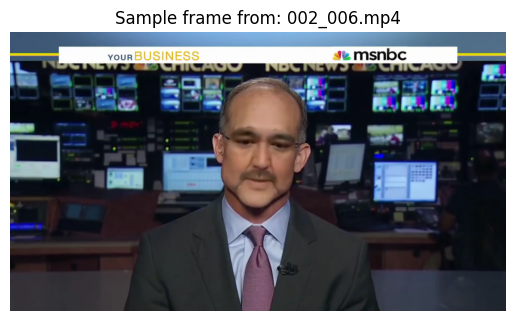

In [ ]:
def show_sample_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.title(f"Sample frame from: {os.path.basename(video_path)}")
        plt.axis('off')
        plt.show()
    else:
        print("Failed to read video.")
    cap.release()

# Example usage
sample_video = os.path.join(dataset_path, "Deepfakes", "002_006.mp4")
show_sample_frame(sample_video)

### Define Frame Extraction Function

In [ ]:
def extract_frames_from_video(video_path, max_frames=10):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return frames

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        cap.release()
        return frames

    step = max(1, frame_count // max_frames)
    frame_idx = 0

    # Load face cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    while cap.isOpened() and len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % step == 0:
            # Convert to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Detect faces
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) > 0:
                # Get the largest face
                largest_face = max(faces, key=lambda x: x[2] * x[3])
                x, y, w, h = largest_face

                # Add padding
                padding = 20
                x = max(0, x - padding)
                y = max(0, y - padding)
                w = min(frame.shape[1] - x, w + 2*padding)
                h = min(frame.shape[0] - y, h + 2*padding)

                # Crop face
                face_crop = frame_rgb[y:y+h, x:x+w]

                if face_crop.size > 0:
                    # Resize to standard size
                    face_resized = cv2.resize(face_crop, (224, 224))
                    frames.append(face_resized)

        frame_idx += 1

    cap.release()
    return frames

### Explore Dataset Structure

In [ ]:
def explore_kaggle_dataset(dataset_path):
    print("Dataset Structure:")
    print("="*50)

    # Check common folder names
    folders = ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter',
               'FaceSwap', 'NeuralTextures', 'original', 'csv']

    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.exists(folder_path):
            if folder == 'csv':
                files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
                print(f"{folder}/: {len(files)} CSV files")
                if files:
                    print(f"  CSV files: {files}")
            else:
                video_files = [f for f in os.listdir(folder_path)
                              if f.lower().endswith(('.mp4', '.avi', '.mov'))]
                print(f"{folder}/: {len(video_files)} videos")
                if video_files:
                    print(f"  Sample files: {video_files[:3]}...")
        else:
            print(f"{folder}/: NOT FOUND")

    # Also check what's actually in the dataset path
    print(f"\nActual contents of {dataset_path}:")
    try:
        actual_contents = os.listdir(dataset_path)
        for item in actual_contents:
            item_path = os.path.join(dataset_path, item)
            if os.path.isdir(item_path):
                sub_items = os.listdir(item_path)
                print(f"{item}/: {len(sub_items)} items")
                if len(sub_items) <= 10:
                    print(f"  Contents: {sub_items}")
                else:
                    print(f"  Sample contents: {sub_items[:5]}...")
            else:
                print(f"{item} (file)")
    except Exception as e:
        print(f"Error reading directory: {e}")

# Explore the dataset
if dataset_path:
    explore_kaggle_dataset(dataset_path)
else:
    print("Cannot explore dataset - path not found")

Dataset Structure:
DeepFakeDetection/: 1000 videos
  Sample files: ['02_09__kitchen_pan__9TDCEK1Q.mp4', '02_13__exit_phone_room__CP5HFV3K.mp4', '24_10__walking_down_street_outside_angry__356HPS7R.mp4']...
Deepfakes/: 1000 videos
  Sample files: ['479_706.mp4', '481_469.mp4', '184_205.mp4']...
Face2Face/: 1000 videos
  Sample files: ['479_706.mp4', '481_469.mp4', '184_205.mp4']...
FaceShifter/: 1000 videos
  Sample files: ['479_706.mp4', '481_469.mp4', '184_205.mp4']...
FaceSwap/: 1000 videos
  Sample files: ['479_706.mp4', '481_469.mp4', '184_205.mp4']...
NeuralTextures/: 1000 videos
  Sample files: ['479_706.mp4', '481_469.mp4', '184_205.mp4']...
original/: 1000 videos
  Sample files: ['123.mp4', '738.mp4', '479.mp4']...
csv/: 10 CSV files
  CSV files: ['FaceSwap.csv', 'FaceShifter.csv', 'DeepFakeDetection.csv', 'Face2Face.csv', 'Deepfakes.csv', 'Mean_Data.csv', 'original.csv', 'NeuralTextures.csv', 'FF++_Metadata_Shuffled.csv', 'FF++_Metadata.csv']

Actual contents of /kaggle/input/f

### Create Balanced Dataset Function

In [ ]:
def create_balanced_dataset(dataset_path, samples_per_class=500, max_frames_per_video=5):
    """Create a balanced dataset from the FaceForensics++ data"""
    print(f"Creating balanced dataset with {samples_per_class} samples per class...")

    frame_paths = []
    labels = []
    output_dir = os.path.join(base_dir, 'data', 'frames')
    os.makedirs(output_dir, exist_ok=True)

    real_count = 0
    fake_count = 0

    # Check actual folder structure
    actual_folders = os.listdir(dataset_path)
    print(f"Available folders: {actual_folders}")

    # Process real videos (original folder)
    original_folders = [f for f in actual_folders if 'original' in f.lower() or 'real' in f.lower()]
    if not original_folders:
        # Try common variations
        for folder in actual_folders:
            folder_path = os.path.join(dataset_path, folder)
            if os.path.isdir(folder_path):
                sub_folders = os.listdir(folder_path)
                if any('original' in sub.lower() for sub in sub_folders):
                    original_folders = [os.path.join(folder, sub) for sub in sub_folders if 'original' in sub.lower()]
                    break

    print(f"Original folders found: {original_folders}")

    # Process original videos
    for orig_folder in original_folders:
        if real_count >= samples_per_class:
            break

        folder_path = os.path.join(dataset_path, orig_folder)
        if os.path.exists(folder_path):
            video_files = [f for f in os.listdir(folder_path)
                          if f.lower().endswith(('.mp4', '.avi', '.mov'))]

            for video_file in tqdm(video_files, desc=f"Processing real videos from {orig_folder}"):
                if real_count >= samples_per_class:
                    break

                video_path = os.path.join(folder_path, video_file)
                frames = extract_frames_from_video(video_path, max_frames_per_video)

                for i, frame in enumerate(frames):
                    if real_count >= samples_per_class:
                        break

                    frame_path = os.path.join(output_dir, f'real_{real_count}_{video_file}_{i}.jpg')

                    # Save frame
                    frame_pil = Image.fromarray(frame)
                    frame_pil.save(frame_path)

                    frame_paths.append(frame_path)
                    labels.append(0)  # 0 for real
                    real_count += 1

    # Process fake videos
    fake_folders = [f for f in actual_folders if f not in original_folders and
                    os.path.isdir(os.path.join(dataset_path, f))]

    print(f"Processing fake folders: {fake_folders}")

    for folder in fake_folders:
        if fake_count >= samples_per_class:
            break

        folder_path = os.path.join(dataset_path, folder)
        video_files = [f for f in os.listdir(folder_path)
                      if f.lower().endswith(('.mp4', '.avi', '.mov'))]

        for video_file in tqdm(video_files, desc=f"Processing {folder}"):
            if fake_count >= samples_per_class:
                break

            video_path = os.path.join(folder_path, video_file)
            frames = extract_frames_from_video(video_path, max_frames_per_video)

            for i, frame in enumerate(frames):
                if fake_count >= samples_per_class:
                    break

                frame_path = os.path.join(output_dir, f'fake_{fake_count}_{folder}_{video_file}_{i}.jpg')

                # Save frame
                frame_pil = Image.fromarray(frame)
                frame_pil.save(frame_path)

                frame_paths.append(frame_path)
                labels.append(1)  # 1 for fake
                fake_count += 1

    print(f"Dataset created: {real_count} real + {fake_count} fake = {len(frame_paths)} total")

    # Shuffle data
    combined = list(zip(frame_paths, labels))
    random.shuffle(combined)
    frame_paths, labels = zip(*combined)

    return list(frame_paths), list(labels)

### Create the Dataset

In [ ]:
if dataset_path:
    print("Creating balanced dataset...")
    frame_paths, labels = create_balanced_dataset(dataset_path, samples_per_class=2000)

    if len(frame_paths) > 0:
        print(f"Dataset created successfully with {len(frame_paths)} samples")
        print(f"Real samples: {labels.count(0)}")
        print(f"Fake samples: {labels.count(1)}")

        # Save the dataset info
        dataset_info = {
            'frame_paths': frame_paths,
            'labels': labels,
            'total_samples': len(frame_paths),
            'real_samples': labels.count(0),
            'fake_samples': labels.count(1)
        }

        with open(f'{base_dir}/data/dataset_info.pkl', 'wb') as f:
            pickle.dump(dataset_info, f)

        print("Dataset info saved successfully!")
    else:
        print("No data found. Please check the dataset path and structure.")
else:
    print("Cannot create dataset - dataset path not found")

Creating balanced dataset...
Creating balanced dataset with 2000 samples per class...
Available folders: ['Face2Face', 'csv', 'Deepfakes', 'DeepFakeDetection', 'original', 'NeuralTextures', 'FaceShifter', 'FaceSwap']
Original folders found: ['original']


Processing real videos from original:  40%|████      | 402/1000 [33:03<49:11,  4.94s/it]


Processing fake folders: ['Face2Face', 'csv', 'Deepfakes', 'DeepFakeDetection', 'NeuralTextures', 'FaceShifter', 'FaceSwap']


Processing Face2Face:  40%|████      | 401/1000 [32:57<49:13,  4.93s/it]

Dataset created: 2000 real + 2000 fake = 4000 total
Dataset created successfully with 4000 samples
Real samples: 2000
Fake samples: 2000
Dataset info saved successfully!


### Split the Dataset

In [ ]:
if len(frame_paths) > 0:
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        frame_paths, labels, test_size=0.4, random_state=42, stratify=labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"Dataset split completed:")
    print(f"Train: {len(X_train)} samples")
    print(f"Validation: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")

    print(f"\nTrain distribution - Real: {y_train.count(0)}, Fake: {y_train.count(1)}")
    print(f"Val distribution - Real: {y_val.count(0)}, Fake: {y_val.count(1)}")
    print(f"Test distribution - Real: {y_test.count(0)}, Fake: {y_test.count(1)}")
else:
    print("No data available for splitting")

Dataset split completed:
Train: 2400 samples
Validation: 800 samples
Test: 800 samples

Train distribution - Real: 1200, Fake: 1200
Val distribution - Real: 400, Fake: 400
Test distribution - Real: 400, Fake: 400


### Define Data Transforms

In [ ]:
def get_transforms():
    train_transform = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussNoise(p=0.1),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    return train_transform, val_transform

# Get transforms
train_transform, val_transform = get_transforms()
print("Data transforms created successfully!")
print("Train transforms include: Resize, HorizontalFlip, Rotate, Brightness/Contrast, GaussNoise, Normalize")
print("Validation transforms include: Resize, Normalize")

Data transforms created successfully!
Train transforms include: Resize, HorizontalFlip, Rotate, Brightness/Contrast, GaussNoise, Normalize
Validation transforms include: Resize, Normalize


### Define Custom Dataset Class

In [ ]:
class AlbumentationsDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

### Create Datasets and DataLoaders

In [ ]:
if len(frame_paths) > 0:
    train_dataset = AlbumentationsDataset(X_train, y_train, train_transform)
    val_dataset = AlbumentationsDataset(X_val, y_val, val_transform)
    test_dataset = AlbumentationsDataset(X_test, y_test, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    print("Datasets and DataLoaders created successfully!")
    print(f"Train DataLoader: {len(train_loader)} batches")
    print(f"Validation DataLoader: {len(val_loader)} batches")
    print(f"Test DataLoader: {len(test_loader)} batches")

    # Test loading one batch
    try:
        sample_batch = next(iter(train_loader))
        print(f"Sample batch shape: {sample_batch[0].shape}")
        print(f"Sample labels shape: {sample_batch[1].shape}")
    except Exception as e:
        print(f"Error loading sample batch: {e}")
else:
    print("Cannot create DataLoaders - no data available")

Datasets and DataLoaders created successfully!
Train DataLoader: 75 batches
Validation DataLoader: 25 batches
Test DataLoader: 25 batches
Sample batch shape: torch.Size([32, 3, 224, 224])
Sample labels shape: torch.Size([32])


### Define the Model

In [ ]:
class DeepfakeDetector(nn.Module):
    def __init__(self, model_name='efficientnet_b4', num_classes=2, pretrained=True):
        super(DeepfakeDetector, self).__init__()

        # Load pre-trained model
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)

        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 380, 380)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

### Create the Model

In [ ]:
model = DeepfakeDetector('efficientnet_b4', num_classes=2, pretrained=True)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model moved to: {device}")

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Model created successfully!
Total parameters: 18,467,658
Trainable parameters: 18,467,658
Model moved to: cuda


### Define Training Function

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc='Training'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{base_dir}/models/best_model.pth')
            print(f'New best model saved with validation accuracy: {best_val_acc:.2f}%')

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step()
        print()

    return train_losses, val_losses, train_accs, val_accs

### Start Training

In [ ]:
if len(frame_paths) > 0:
    print("Starting training...")
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, num_epochs=10
    )
    print("Training completed!")
else:
    print("Cannot start training - no data available")

Starting training...
Epoch 1/10
----------


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.68it/s]


Train Loss: 0.4423, Train Acc: 78.08%
Val Loss: 0.1766, Val Acc: 92.38%
New best model saved with validation accuracy: 92.38%

Epoch 2/10
----------


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.06it/s]


Train Loss: 0.2045, Train Acc: 89.88%
Val Loss: 0.1874, Val Acc: 91.38%

Epoch 3/10
----------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]


Train Loss: 0.1705, Train Acc: 91.71%
Val Loss: 0.1064, Val Acc: 96.00%
New best model saved with validation accuracy: 96.00%

Epoch 4/10
----------


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]


Train Loss: 0.1252, Train Acc: 93.33%
Val Loss: 0.1335, Val Acc: 95.62%

Epoch 5/10
----------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s]


Train Loss: 0.1173, Train Acc: 93.79%
Val Loss: 0.1356, Val Acc: 95.00%

Epoch 6/10
----------


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.21it/s]


Train Loss: 0.1159, Train Acc: 93.79%
Val Loss: 0.1546, Val Acc: 92.88%

Epoch 7/10
----------


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s]


Train Loss: 0.1320, Train Acc: 93.62%
Val Loss: 0.0858, Val Acc: 97.00%
New best model saved with validation accuracy: 97.00%

Epoch 8/10
----------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s]


Train Loss: 0.0886, Train Acc: 94.54%
Val Loss: 0.0724, Val Acc: 97.88%
New best model saved with validation accuracy: 97.88%

Epoch 9/10
----------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Train Loss: 0.0817, Train Acc: 94.88%
Val Loss: 0.0673, Val Acc: 97.62%

Epoch 10/10
----------


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]

Train Loss: 0.0783, Train Acc: 94.71%
Val Loss: 0.0734, Val Acc: 97.75%

Training completed!


### Plot Training History

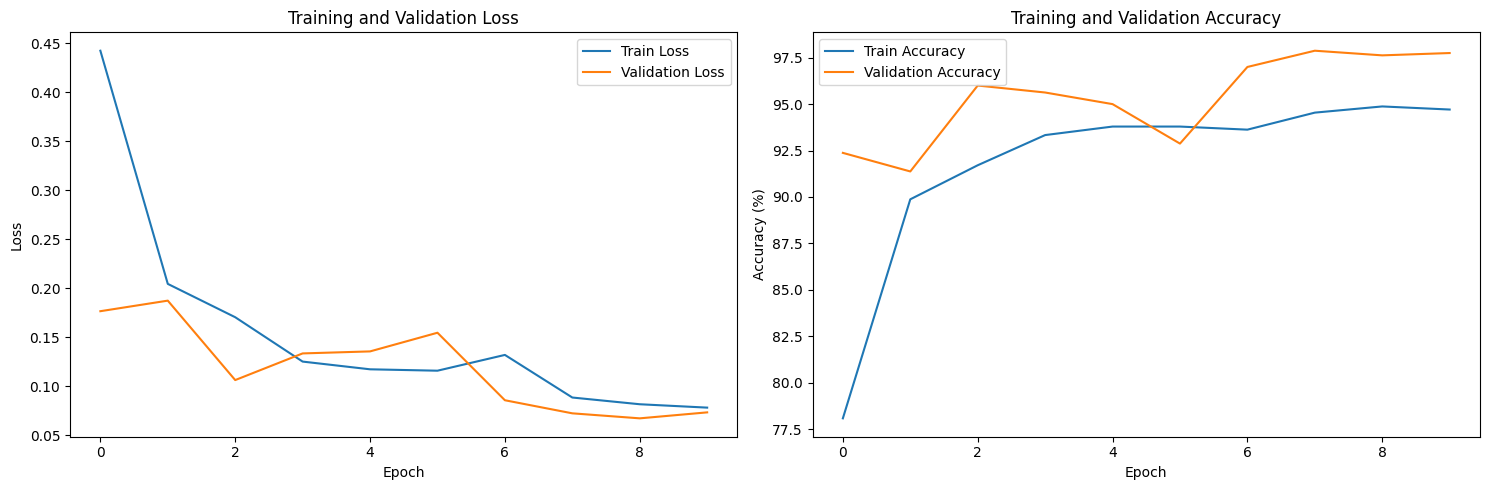

In [ ]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot the results
if 'train_losses' in locals():
    plot_training_history(train_losses, val_losses, train_accs, val_accs)
else:
    print("No training history to plot")

### Define Evaluation Function

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy:.4f}')

    # Classification report
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, all_preds, all_labels

### Evaluate the Model

Best model loaded successfully!
Evaluating on test set...


Testing: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]


Test Accuracy: 0.9762

Classification Report:
              precision    recall  f1-score   support

        Real       0.97      0.98      0.98       400
        Fake       0.98      0.97      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



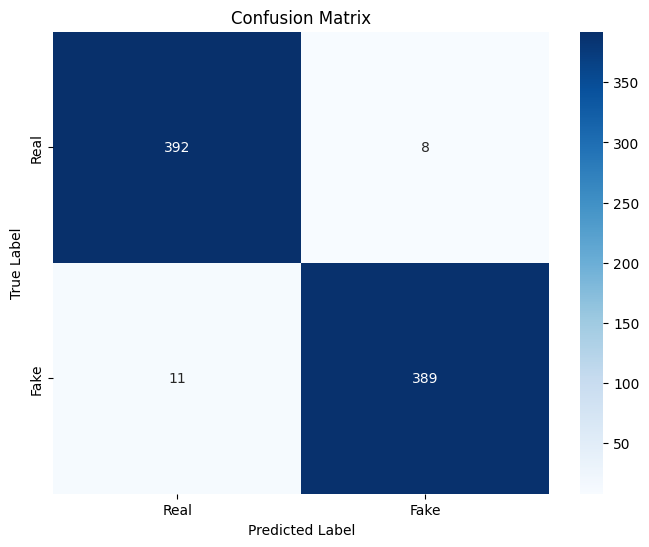

In [ ]:
if 'model' in locals() and len(frame_paths) > 0:
    # Load best model
    try:
        model.load_state_dict(torch.load(f'{base_dir}/models/best_model.pth'))
        print("Best model loaded successfully!")

        # Evaluate on test set
        print("Evaluating on test set...")
        test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)

    except FileNotFoundError:
        print("Best model not found. Using current model state.")
        test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)

else:
    print("Cannot evaluate - model or data not available")

### Save Results

In [ ]:
if 'train_losses' in locals():
    results = {
        'test_accuracy': test_accuracy if 'test_accuracy' in locals() else None,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': max(val_accs) if val_accs else None
    }

    with open(f'{base_dir}/results/training_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("Results saved successfully!")
    print(f"Best validation accuracy: {max(val_accs):.2f}%")
    if 'test_accuracy' in locals():
        print(f"Test accuracy: {test_accuracy:.4f}")
else:
    print("No results to save")

Results saved successfully!
Best validation accuracy: 97.88%
Test accuracy: 0.9762


### Display Summary

In [ ]:
print("="*50)
print("DEEPFAKE DETECTION MODEL SUMMARY")
print("="*50)

if 'dataset_info' in locals():
    print(f"Dataset: {dataset_info['total_samples']} samples")
    print(f"Real samples: {dataset_info['real_samples']}")
    print(f"Fake samples: {dataset_info['fake_samples']}")

if 'model' in locals():
    print(f"Model: EfficientNet-B4 with {total_params:,} parameters")

if 'train_losses' in locals():
    print(f"Training epochs: {len(train_losses)}")
    print(f"Best validation accuracy: {max(val_accs):.2f}%")

if 'test_accuracy' in locals():
    print(f"Final test accuracy: {test_accuracy:.4f}")

print("="*50)

DEEPFAKE DETECTION MODEL SUMMARY
Dataset: 4000 samples
Real samples: 2000
Fake samples: 2000
Model: EfficientNet-B4 with 18,467,658 parameters
Training epochs: 10
Best validation accuracy: 97.88%
Final test accuracy: 0.9762


In [ ]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import timm

video_path = '/content/drive/MyDrive/ai_vedio.mp4'
model_path = '/content/drive/MyDrive/deepfake_detection/models/best_model.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Inspect the checkpoint to help debug mismatches ---
checkpoint = torch.load(model_path, map_location=device)
print("Checkpoint type:", type(checkpoint))
if isinstance(checkpoint, dict):
    print("Checkpoint keys:", checkpoint.keys())
    if "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    elif "state_dict" in checkpoint:
        state_dict = checkpoint["state_dict"]
    else:
        state_dict = checkpoint
else:
    # If checkpoint is not a dict, it's likely a full model
    state_dict = None

if state_dict is not None:
    print("First 5 state dict keys:", list(state_dict.keys())[:5])

# --- Try to fix possible prefix issues ---
def clean_state_dict(state_dict):
    # Remove 'module.' or 'model.' prefix if present
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("module."):
            new_k = k[7:]
        elif k.startswith("model."):
            new_k = k[6:]
        else:
            new_k = k
        new_state_dict[new_k] = v
    return new_state_dict

# --- Try loading as state_dict or full model ---
try:
    if state_dict is not None:
        # Clean state dict keys
        state_dict = clean_state_dict(state_dict)
        model = timm.create_model('efficientnet_b4', pretrained=False, num_classes=2)
        missing, unexpected = model.load_state_dict(state_dict, strict=False)
        print("Model loaded with strict=False.")
        print("Missing keys:", missing)
        print("Unexpected keys:", unexpected)
    else:
        # If the checkpoint is a full model object
        model = checkpoint
        print("Loaded full model object from checkpoint.")
except RuntimeError as e:
    print("Model loading error:", e)
    raise

model.to(device)
model.eval()

# --- Preprocessing for EfficientNetB4 ---
preprocess = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def sample_frames_from_video(video_path, num_frames=32):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < 1:
        print("Unable to read video or video is empty.")
        return []
    frame_idxs = np.linspace(0, total_frames-1, num_frames, dtype=int)
    frames = []
    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(frame)
        frames.append(img_pil)
    cap.release()
    return frames

frames = sample_frames_from_video(video_path, num_frames=32)
if len(frames) == 0:
    print("No frames extracted from video. Exiting.")
else:
    preds = []
    with torch.no_grad():
        for img in frames:
            input_tensor = preprocess(img).unsqueeze(0).to(device)
            output = model(input_tensor)
            prob = torch.softmax(output, 1)
            pred = prob.cpu().numpy()[0]
            preds.append(pred)

    preds = np.array(preds)  # (num_frames, 2)
    mean_pred = preds.mean(axis=0)
    classes = ['real', 'deepfake']  # Adjust if your order is different

    print(f"Average prediction over {len(frames)} frames:")
    for i, cls in enumerate(classes):
        print(f"{cls}: {mean_pred[i]:.4f}")

    print(f"\nFinal decision: {classes[np.argmax(mean_pred)]} (confidence: {mean_pred.max():.4f})")

Checkpoint type: <class 'collections.OrderedDict'>
Checkpoint keys: odict_keys(['backbone.conv_stem.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.bn1.num_batches_tracked', 'backbone.blocks.0.0.conv_dw.weight', 'backbone.blocks.0.0.bn1.weight', 'backbone.blocks.0.0.bn1.bias', 'backbone.blocks.0.0.bn1.running_mean', 'backbone.blocks.0.0.bn1.running_var', 'backbone.blocks.0.0.bn1.num_batches_tracked', 'backbone.blocks.0.0.se.conv_reduce.weight', 'backbone.blocks.0.0.se.conv_reduce.bias', 'backbone.blocks.0.0.se.conv_expand.weight', 'backbone.blocks.0.0.se.conv_expand.bias', 'backbone.blocks.0.0.conv_pw.weight', 'backbone.blocks.0.0.bn2.weight', 'backbone.blocks.0.0.bn2.bias', 'backbone.blocks.0.0.bn2.running_mean', 'backbone.blocks.0.0.bn2.running_var', 'backbone.blocks.0.0.bn2.num_batches_tracked', 'backbone.blocks.0.1.conv_dw.weight', 'backbone.blocks.0.1.bn1.weight', 'backbone.blocks.0.1.bn1.bias', 'backbone.bloc